In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables

print ('Success')



Welcome to JupyROOT 6.24/06
Success


# Reading in .pkl files

In [2]:
HNL_masses = Constants.HNL_mass_samples #in MeV

Run = "run3" #so far either "run1" or "run3"

FLATTEN = False

only_presel = True

if FLATTEN == True:
    Flat_state = "flattened"
else:
    Flat_state = "unflattened"
    
if only_presel:
    variables_string = "Presel_vars"
else:
    variables_string = "my_vars"

print(f"Loading {Run} pickles")

loc_pkls = f"pkl_files/{Run}/current_files/{variables_string}/"

overlay_from_pkl = pd.read_pickle(loc_pkls+f"overlay_{Run}_{variables_string}_{Flat_state}.pkl")
#FLAT_overlay_from_pkl = pd.read_pickle(loc_pkls+"overlay_run1_Aditya_vars_flattened.pkl")
dirt_from_pkl = pd.read_pickle(loc_pkls+f"dirt_{Run}_{variables_string}_{Flat_state}.pkl")
EXT_from_pkl = pd.read_pickle(loc_pkls+f"EXT_{Run}_{variables_string}_{Flat_state}.pkl")

signal_samples_dict = {}
#signal_dfs_list = []

for HNL_mass in HNL_masses:
    signal_from_pkl = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_{Run}_{variables_string}_{Flat_state}.pkl")
    signal_samples_dict[HNL_mass] = signal_from_pkl



print(f"Successfully loaded {Run} pkls")

print("Overlay .pkl is "+str(len(overlay_from_pkl))+" entries long.")
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")
print("Dirt .pkl is "+str(len(dirt_from_pkl))+" entries long.")
print("EXT .pkl is "+str(len(EXT_from_pkl))+" entries long.")

for HNL_mass in HNL_masses:
    print(f"{HNL_mass}MeV Signal .pkl is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")



Loading run3 pickles
Successfully loaded run3 pkls
Overlay .pkl is 748702 entries long.
Dirt .pkl is 389264 entries long.
EXT .pkl is 3211097 entries long.
20MeV Signal .pkl is 44806 entries long.
50MeV Signal .pkl is 45383 entries long.
100MeV Signal .pkl is 44970 entries long.
150MeV Signal .pkl is 44843 entries long.
180MeV Signal .pkl is 45826 entries long.
200MeV Signal .pkl is 45003 entries long.


# Functions

In [3]:
#Defining functions
def Preselection_with_list(df_cut, cut_dict, Efficiency_list):
    NumEvs = len(df_cut)
    for cut in cut_dict.keys():
        df_cut=df_cut.query(cut_dict[cut])
        Efficiency_list.append(len(df_cut)/NumEvs)
    Selected = df_cut.copy()
    return Selected
      
def Edit_Weight_Tune(df_to_Tune): #This is taken from Aditya's code, Owen also has the same in his for overlay and dirt, there is the same block in PELEE code
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] > 50, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ np.isnan(df_to_Tune['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    return df_to_Tune

def MC_weight_branch(df_MC): #Writes a new branch called "weight" including, ppfx, weightSplineTimesTune AND if pi0 are present, scales by pi0 factor
    df_MC["weight"] = df_MC["ppfx_cv"]*df_MC["weightSplineTimesTune"] 
    df_MC.loc[df_MC["npi0"]>0,"weight"] = df_MC["weight"][df_MC["npi0"]>0]*pi0_scaling_factor #If MC event contains pi0, need to scale down, derived from BNB data
    
def Plot_one_variable(signal, background, variable_name, numbins, range_lims=None, loghist=False):
    plt.figure(figsize=(12,8),facecolor='white')
    plot1 = plt.figure(1)
    plt.hist(signal[variable_name],bins=numbins,label="Signal",alpha=0.5, range=range_lims)
    plt.hist(background[variable_name],bins=numbins,label="Background",alpha=0.5, range=range_lims)
    if loghist == True:
        plt.yscale("log")
    else:
        plt.yscale("linear")
    plt.xlabel(variable_name)
    plt.ylabel('Number of events')
    plt.legend()
    


# Plotting variables before preselection

In [4]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = 200 #only plotting one at a time
variable = "crtveto"
samples = {"overlay":overlay_from_pkl,
           "dirtoverlay":dirt_from_pkl,
           "beamoff":EXT_from_pkl,
           "signal":signal_samples_dict[HNL_mass]}
samples.update(signal_samples_dict)
if Run == "run1":
    sample_norms = {"overlay":Constants.SF_overlay_run1,
           "dirtoverlay":Constants.SF_dirt_run1,
           "beamoff":Constants.SF_EXT_run1,
           "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
elif Run == "run3":
    sample_norms = {"overlay":Constants.SF_overlay_run3,
           "dirtoverlay":Constants.SF_dirt_run3,
           "beamoff":Constants.SF_EXT_run3,
           "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
    
PT.HNL_scaling_calculator(samples,sample_norms)


The ratio of overlay to HNL events is 54005

The ratio of all bkgs to HNL events is 375468



In [5]:
for sample in samples:
    print(sample)

overlay
dirtoverlay
beamoff
signal
20
50
100
150
180
200


In [ ]:
PT.Plot_preselection_variable(variable, samples, sample_norms, xlabel=[],xlims=[0,2],bins=2, HNL_mass=HNL_mass,HNLplotscale=30000,cutline=1.0)
# plt.axvline(x=16.5, lw=3, color='green', linestyle = 'dashed')

#plt.savefig("plots/Preselection_variables/" + Run + "_" + str(HNL_mass) + "_MeV_" + str(variable)+".png")

## Plot only signal samples before preselection

In [4]:
#Need a new plotting function for this
print(overlay_from_pkl.keys())
print()
print(EXT_from_pkl.keys())

Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps', 'crtveto',
       'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight'],
      dtype='object')

Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps', 'crtveto'],
      dtype='object')


# Pre-selection cuts

In [6]:
def Preselection_weighted_efficiency(samples, cut_dict, Efficiency_dict, Preselected): #Need to account for weigthing in overlay and dirt samples
    for sample in samples:
        if sample == "overlay" or sample == "dirtoverlay":
            weight = samples[sample]["weight"]
            NumEvs = sum(weight)
        else:
            NumEvs = len(samples[sample])
        
        effic_list = [1.0]
        for cut in cut_dict.keys():
            samples[sample]=samples[sample].query(cut_dict[cut])
            if sample == "overlay" or sample == "dirtoverlay":
                weight = samples[sample]["weight"]
                Num_selected = sum(weight)
            else:
                Num_selected = len(samples[sample])
            effic_list.append(Num_selected/NumEvs)
        Efficiency_dict[sample]=effic_list
        #samples.update()
        Selected = samples[sample].copy()
        placeholder_dict = {sample:Selected}
        Preselected.update(placeholder_dict) 
    

In [7]:
#Make cuts on signal
if Run == "run1": 
    if FLATTEN == True:
        Preselection_dict = Constants.Preselection_dict #Have also saved this in Constants.py, it is also here in case I want to add to or edit the cuts
    else:
        Preselection_dict = Constants.Preselection_dict_for_plot
elif Run == "run3":
    if FLATTEN == True:
        Preselection_dict = Constants.Preselection_dict
    else:
        Preselection_dict = Constants.Preselection_dict_for_plot
    Preselection_dict.update(Constants.Preselection_dict_crtveto) #Adding crtveto cut
    
print("Preselection is:" + "\n")
print(Preselection_dict)
print()

#"Containment":""
#"n_track":"n_track < 5"
#"shr_energy_tot":"shr_energy_tot < 1.0"
#"trk_len":"trk_len < 50.0"

#print(Signal_run1.numentries)
print("Numbers of rows in dataframes BEFORE Preselection:")
print("Overlay file has " + str(len(overlay_from_pkl)))
print("Dirt file has " + str(len(dirt_from_pkl)))
print("EXT file has " + str(len(EXT_from_pkl)))
#print(len(signal_from_pkl))



Preselection is:

{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.55 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'contained_fraction': 'contained_fraction > 0.9', 'trk_score': 'trk_score < 0.97', 'n_pfps': 'n_pfps < 6', 'crtveto': 'crtveto==0'}

Numbers of rows in dataframes BEFORE Preselection:
Overlay file has 748702
Dirt file has 389264
EXT file has 3211097


In [8]:
#Make cuts on bkg
# Preselection_efficiency_overlay = [1.0]
# Preselection_efficiency_dirt = [1.0]
# Preselection_efficiency_EXT = [1.0]

# Preselection_signal_max = []
# Preselection_signal_min = []

# Preselection_efficiency_signal_dict = {}
# for HNL_mass in HNL_masses:
#     Preselection_efficiency_signal_dict[HNL_mass] = [1.0]

# Selected_signal_from_pkl_dict = {}

    
# Selected_overlay_from_pkl = Preselection_with_list(overlay_from_pkl, Preselection_dict, Preselection_efficiency_overlay)
# Selected_dirt_from_pkl = Preselection_with_list(dirt_from_pkl, Preselection_dict, Preselection_efficiency_dirt)
# Selected_EXT_from_pkl = Preselection_with_list(EXT_from_pkl, Preselection_dict, Preselection_efficiency_EXT)

# for HNL_mass in HNL_masses:
#     Selected_signal_from_pkl_dict[HNL_mass] = Preselection_with_list(signal_samples_dict[HNL_mass], Preselection_dict, Preselection_efficiency_signal_dict[HNL_mass])

# print("AFTER Preselection:")
# print("Overlay .pkl is "+str(len(Selected_overlay_from_pkl))+" entries long.")
# print("Dirt .pkl is "+str(len(Selected_dirt_from_pkl))+" entries long.")
# print("EXT .pkl is "+str(len(Selected_EXT_from_pkl))+" entries long.")

# for HNL_mass in HNL_masses:
#     print(f"{HNL_mass}MeV Signal .pkl is "+str(len(Selected_signal_from_pkl_dict[HNL_mass]))+" entries long.")

Efficiency_dict = {}
Preselected_dict = {}
    
Preselection_weighted_efficiency(samples, Preselection_dict, Efficiency_dict, Preselected_dict)

print(Efficiency_dict)

{'overlay': [1.0, 0.4318984838245997, 0.4049839593228192, 0.27120382631468815, 0.17122708269547224, 0.05127564963921976, 0.036655494987959884, 0.036328605084700136, 0.03216327444734844], 'dirtoverlay': [1.0, 0.266215503056719, 0.25031447386200084, 0.13878330764194058, 0.09990176587297885, 0.014224486260637128, 0.01228477412639235, 0.012259094177210234, 0.007886967192912738], 'beamoff': [1.0, 0.11676944047470382, 0.10662057234645979, 0.07445928914635715, 0.06095300141976402, 0.010010909044479191, 0.007821003227246015, 0.007795466782847108, 0.003609669841801727], 'signal': [1.0, 0.5316090038441882, 0.5146323578428105, 0.4711019265382308, 0.4688131902317623, 0.352976468235451, 0.34511032597826813, 0.34391040597293515, 0.3364442370508633], 20: [1.0, 0.5645226085792081, 0.5477837789581752, 0.5034816765611748, 0.5011382404142303, 0.3957282506807124, 0.3897022720171406, 0.3863768245324287, 0.37809668347989106], 50: [1.0, 0.5478042438798669, 0.531168058524117, 0.48588678580085054, 0.4830663464

In [10]:
#Working out the maximum and minimum efficiencies for signal "band"
Preselection_signal_max = []
Preselection_signal_min = []

max_presel_effic = 0.0
min_presel_effic = 1.0
# for i in range(len(Preselection_dict)+1):
#     for HNL_mass in HNL_masses:
#         if Preselection_efficiency_signal_dict[HNL_mass][i] > max_presel_effic:
#             max_presel_effic = Preselection_efficiency_signal_dict[HNL_mass][i]
#         if Preselection_efficiency_signal_dict[HNL_mass][i] < min_presel_effic:
#             min_presel_effic = Preselection_efficiency_signal_dict[HNL_mass][i]
#     Preselection_signal_max.append(max_presel_effic)
#     Preselection_signal_min.append(min_presel_effic)
#     max_presel_effic = 0.0
    
for i in range(len(Preselection_dict)+1):
    for HNL_mass in HNL_masses:
        if Efficiency_dict[HNL_mass][i] > max_presel_effic:
            max_presel_effic = Efficiency_dict[HNL_mass][i]
        if Efficiency_dict[HNL_mass][i] < min_presel_effic:
            min_presel_effic = Efficiency_dict[HNL_mass][i]
    Preselection_signal_max.append(max_presel_effic)
    Preselection_signal_min.append(min_presel_effic)
    max_presel_effic = 0.0

In [11]:
print(Preselection_signal_max)
print(Preselection_signal_min)

[1.0, 0.6038623642486006, 0.5858885444773989, 0.5435407978948776, 0.5409093950003345, 0.4034520437972482, 0.39250273175300493, 0.3915661307227438, 0.38300292130321345]
[1.0, 0.5316090038441882, 0.5146323578428105, 0.4711019265382308, 0.4688131902317623, 0.352976468235451, 0.34511032597826813, 0.34391040597293515, 0.3364442370508633]


# Save pkls

In [15]:
print_vals = input("Do you want to save the pickle files? y/n ")
if print_vals == "y":
    loc_pkls = f"pkl_files/{Run}/current_files/"

    print(f"Saving {Run} Preselected overlay .pkl")
    Selected_overlay_from_pkl.to_pickle(loc_pkls+f"Preselected_overlay_{Run}_my_vars_flattened.pkl")

    print(f"Saving {Run} Preselected dirt .pkl")
    Selected_dirt_from_pkl.to_pickle(loc_pkls+f"Preselected_dirt_{Run}_my_vars_flattened.pkl")

    print(f"Saving {Run} Preselected EXT .pkl")
    Selected_EXT_from_pkl.to_pickle(loc_pkls+f"Preselected_EXT_{Run}_my_vars_flattened.pkl")
    for HNL_mass in HNL_masses:
        print(f"Saving {Run} Preselected {HNL_mass}MeV signal .pkl")
        Selected_signal_from_pkl_dict[HNL_mass].to_pickle(loc_pkls+f"Preselected_signal_{HNL_mass}MeV_{Run}_my_vars_flattened.pkl")
else:
    print("Not saving pickle files, move onto next cell")

Saving run3 Preselected overlay .pkl
Saving run3 Preselected dirt .pkl
Saving run3 Preselected EXT .pkl
Saving run3 Preselected 20MeV signal .pkl
Saving run3 Preselected 50MeV signal .pkl
Saving run3 Preselected 100MeV signal .pkl
Saving run3 Preselected 150MeV signal .pkl
Saving run3 Preselected 180MeV signal .pkl
Saving run3 Preselected 200MeV signal .pkl


# Plotting Efficiencies

Do you want to save the figure? y/n  y


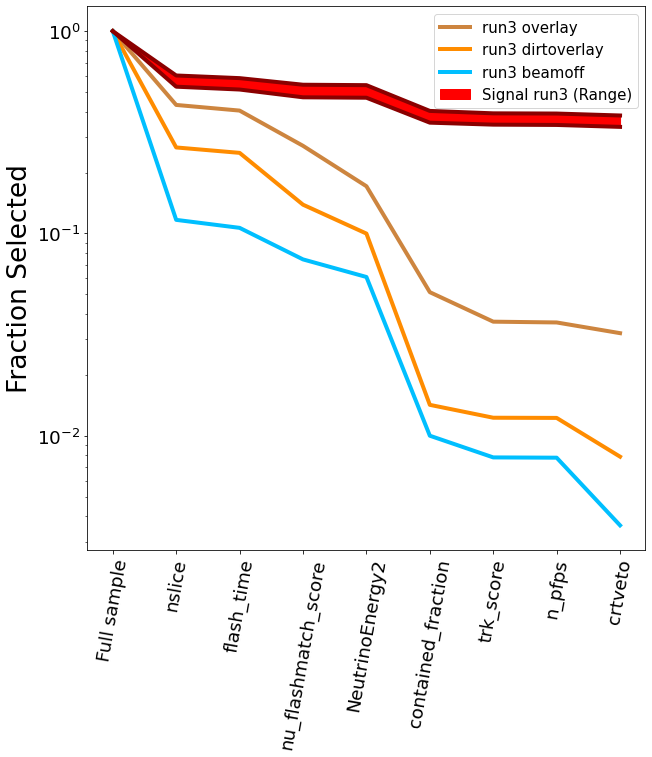

In [19]:
#Signal-only efficiencies
plt.figure(figsize=[10,10])
#print(Preselection_efficiency_signal_dict)
#print(len(Preselection_efficiency_signal_dict[HNL_mass]))
# for HNL_mass in HNL_masses:
#     plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)), Preselection_efficiency_signal_dict[HNL_mass], label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
#plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_signal,label="100 MeV HNL",lw=4,markersize=15)


# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_overlay,label=f"MC {Run} overlay",color='peru',lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_dirt,label=f"MC {Run} dirt",color="darkorange",lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_overlay)+1)),Preselection_efficiency_EXT,label=f"{Run} EXT",color='deepskyblue',lw=4,markersize=15)
# plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
# plt.plot(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
# plt.fill_between(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),Preselection_signal_min,Preselection_signal_max,label=f"Signal {Run} (Range)",color="red")
# plt.ylabel("Fraction Selected")
# plt.xticks(np.array(range(1, len(Preselection_efficiency_signal_dict[HNL_mass])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# #plt.yscale("log")
# plt.legend()

plotting_effic_dict = {'overlay':Efficiency_dict['overlay'], 'dirtoverlay':Efficiency_dict['dirtoverlay'],
                      'beamoff':Efficiency_dict['beamoff']}
plotting_effic_colours = {'overlay':'peru', 'dirtoverlay':'darkorange',
                      'beamoff':'deepskyblue'}
#, 'signal_max':Preselection_signal_max, 'signal_min':Preselection_signal_min}

log = True

if log == True:
    logscale="log"
elif log == False:
    logscale="linear"

for effic in plotting_effic_dict:
    #Efficiency_dict[effic]
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[effic],label=f"{Run} {effic}",color=plotting_effic_colours[effic],lw=4,markersize=15)

plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
plt.fill_between(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,Preselection_signal_max,label=f"Signal {Run} (Range)",color="red")
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict['overlay'])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
plt.yscale(logscale)
plt.legend()

save_fig = input("Do you want to save the figure? y/n ")

if save_fig == 'y':
    plt.savefig("plots/Preselection_efficiencies/" + Run + "_" + Flat_state + "_" + logscale + ".png")

[1.0, 0.5580340693291006, 0.542388254301182, 0.49757659930274084, 0.4948839318613418, 0.37113460502820217, 0.36614608429466283]


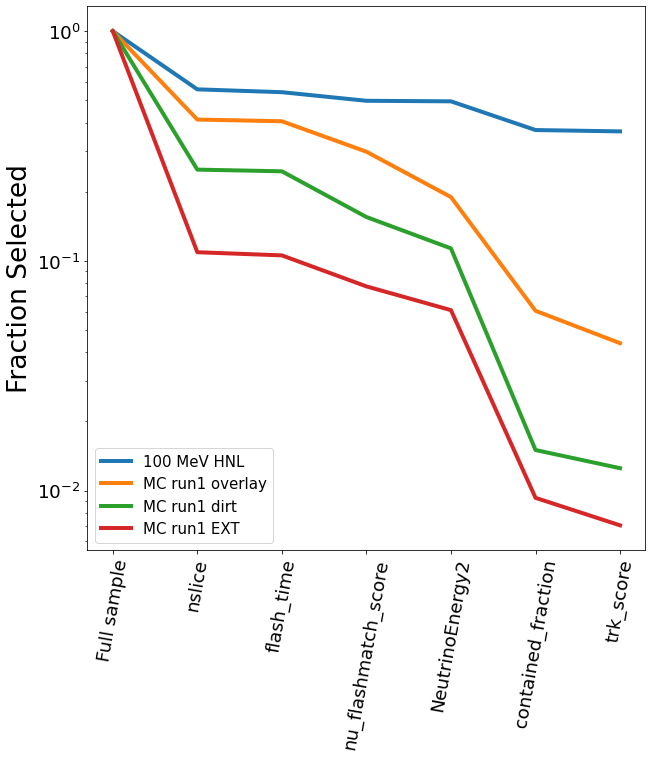

In [15]:
#Plotting efficiency
plt.figure(figsize=[10,10])
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_signal,label="100 MeV HNL",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_overlay,label="MC run1 overlay",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_dirt,label="MC run1 dirt",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_EXT,label="MC run1 EXT",lw=4,markersize=15)
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Preselection_efficiency_signal)+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()

print(Preselection_efficiency_signal)


# Testing code

In [ ]:
#Testing what the variables look like
variable = "dvtx_x_boundary"
def test_variables(df):
    test_signal = df[variable]
    print(type(test_signal))
    print(len(test_signal))
test_variables(df_overlay_run1)
test_variables(df_dirt_run1)
test_variables(df_EXT_run1)
test_variables(df_signal_run1)

In [ ]:
#Single variables
plt.rcParams.update({'font.size': 22})

plot_variable = "n_showers"
range_list=[0,10]

Plot_one_variable(df_signal_run1, df_overlay_run1, plot_variable, 10, range_list, False) #With range
#Plot_one_variable(df_signal_run1, df_NuMI_MC_overlay_pdra_run1, plot_variable, None, loghist=False) #Without range

In [ ]:
#print(overlay_from_pkl['nslice'])
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")

print("-----Unflattened-----")
unique_var = overlay_from_pkl["nslice"].unique()
print(unique_var)
unique_var = overlay_from_pkl["n_pfps"].unique()
print(unique_var)
print(overlay_from_pkl["n_pfps"])
print(type(overlay_from_pkl["n_pfps"][0]))

# for var in overlay_from_pkl.keys():
#     if type(overlay_from_pkl[var][1]) == "numpy.ndarray":
#         print(var)

# print("-----Flattened-----")
# unique_var = FLAT_overlay_from_pkl["nslice"].unique()
# print(unique_var)
# unique_var = FLAT_overlay_from_pkl["n_pfps"].unique()
# print(unique_var)
# print(FLAT_overlay_from_pkl["n_pfps"])
# print(type(FLAT_overlay_from_pkl["n_pfps"]))